In [1]:
import json
import os
import re
import sys
import time
import shutil
import tempfile
import subprocess
import hashlib
from pathlib import Path
from collections import Counter
from concurrent.futures import ProcessPoolExecutor, as_completed
import numpy as np
import pandas as pd
import pickle
import joblib
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import (silhouette_score, accuracy_score, precision_score, recall_score, f1_score, classification_report)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import sentence_transformers
from sentence_transformers import (SentenceTransformer,InputExample, losses)
from torch.utils.data import DataLoader
from datasets import Dataset
import accelerate

C:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.style.use("default")

In [3]:
with open("C:/Users/jyzel/license-classifier/dataset.json", 'r', encoding='utf-8') as f:
    original_data = json.load(f)

print(f"Total records in original dataset: {len(original_data)}")

Total records in original dataset: 718


In [4]:
INPUT_FILE = "C:/Users/jyzel/license-classifier/dataset.json"
CLEANED_FILE = "C:/Users/jyzel/license-classifier/cleaned_research_dataset.json"

with open(INPUT_FILE, "r", encoding="utf-8") as f:
    original_data = json.load(f)

if os.path.exists(CLEANED_FILE):
    print(f"'{CLEANED_FILE}' already exists. Skipping processing.")
    with open(CLEANED_FILE, "r", encoding="utf-8") as f:
        research_dataset = json.load(f)
else:
    print(f"'{CLEANED_FILE}' not found. Starting cleanup...")

    research_dataset = []
    skipped_count = 0
    duplicate_text_count = 0
    duplicate_id_count = 0

    seen_text_hashes = set()
    seen_spdx_ids = set()

    for entry in original_data:

        spdx = entry.get("spdx_license_key")
        name = entry.get("name")
        text = entry.get("text")

        # Basic validation
        if not spdx or not text:
            skipped_count += 1
            continue

        cleaned_text = re.sub(r"\s+", " ", text.strip())

        # Remove useless placeholder texts
        if len(cleaned_text) < 50 or cleaned_text == ".":
            skipped_count += 1
            continue

        #  Duplication checks
        text_hash = hashlib.sha256(cleaned_text.encode("utf-8")).hexdigest()

        if text_hash in seen_text_hashes:
            duplicate_text_count += 1
            continue

        if spdx in seen_spdx_ids:
            duplicate_id_count += 1
            continue

        seen_text_hashes.add(text_hash)
        seen_spdx_ids.add(spdx)

        research_dataset.append({
            "target_spdx": spdx,
            "license_name": name,
            "text": cleaned_text
        })

    # Save cleaned dataset
    with open(CLEANED_FILE, "w", encoding="utf-8") as f:
        json.dump(research_dataset, f, indent=2, ensure_ascii=False)

    print("Processing complete!")
    print(f"Saved {len(research_dataset)} records to '{CLEANED_FILE}'.")
    print(f"Skipped {skipped_count} invalid or empty records.")
    print(f"Removed {duplicate_text_count} duplicate texts.")
    print(f"Removed {duplicate_id_count} duplicate SPDX IDs.")

print(f"Total records ready for research: {len(research_dataset)}")

'C:/Users/jyzel/license-classifier/cleaned_research_dataset.json' already exists. Skipping processing.
Total records ready for research: 680


In [5]:
# Upload the cleaned dataset
with open('C:/Users/jyzel/license-classifier/cleaned_research_dataset.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

## Dataset Preparation & Cleaning
**Objective:**
Construct a clean, minimal, and reproducible dataset suitable for license text analysis and similarity modeling.
**Steps:**
- Loaded the original ScanCode canonical license dataset.
- Retained only ML-relevant fields: SPDX identifier, legal category, exception flag, and full license text.
- Removed incomplete entries.
- Persisted the cleaned dataset for reproducibility.

**Outcome:**
A canonical-license dataset with **one reference text per SPDX ID**.

In [6]:
# Data Preprocessing before similarity search
def normalize_text(text: str) -> str:
    text = text.lower().replace("\r\n", "\n")
    text = re.sub(r'\n{2,}', '\n', text)
    text = re.sub(r'[ \t]+', ' ', text)
    return text.strip()

for entry in data:
    if "content" not in entry or not entry["content"]:
        continue
    if entry.get("content"):
        entry["cleaned_content"] = normalize_text(entry["content"])

with open("C:/Users/jyzel/license-classifier/cleaned_research_dataset.json", "w", encoding="utf-8") as f:
    json.dump(data, f, indent=2)

print("New Cleaned and preprocessed data saved to 'cleaned_research_dataset.json'.")

New Cleaned and preprocessed data saved to 'cleaned_research_dataset.json'.


In [7]:
# Reload the cleaned dataset with the new key attribute "cleaned_content"
with open("C:/Users/jyzel/license-classifier/cleaned_research_dataset.json", "r", encoding="utf-8") as f:
    data = json.load(f)

assert isinstance(data, list)
assert "text" in data[0]

print(f"Loaded {len(data)} records")

Loaded 680 records


## Text Normalization

**Objective:**
Reduce formatting noise while preserving legal meaning.

**Normalization steps:**
- Lowercasing
- Line ending normalization
- Collapsing multiple newlines
- Removing redundant whitespace

**Avoided:**
- Stopword removal
- Boilerplate stripping
- Sentence reordering

**Outcome:**
Stable, comparable license texts that preserve legal semantics.

In [8]:
# Build text and labels lists
texts = []
labels = []

for entry in data:
    if not entry.get("text"):
        continue

    texts.append(entry["text"])
    labels.append(entry["target_spdx"])

assert len(texts) == len(labels)

print(f"Prepared {len(texts)} documents")

Prepared 680 documents


In [9]:
# Build the TF-IDF vectorizer
vectorizer = TfidfVectorizer(analyzer="char_wb", ngram_range=(4, 8), min_df=2, max_df=0.95, sublinear_tf=True, norm="l2", smooth_idf=False)

In [10]:
# Fit the input (texts)
X = vectorizer.fit_transform(texts)
print("TF-IDF matrix shape:", X.shape)

# Feature names verification
feature_names = vectorizer.get_feature_names_out()
print(feature_names[:30])

TF-IDF matrix shape: (680, 119466)
[' " ' ' "),' ' "), ' ' ". ' ' "[]' ' "[]"' ' "[]" ' ' "[_' ' "[__'
 ' "[___' ' "[___]' ' "[___] ' ' "ab' ' "abo' ' "abou' ' "about'
 ' "about"' ' "abw' ' "abwa' ' "abwan' ' "abwand' ' "ac' ' "acc' ' "acce'
 ' "accep' ' "accept' ' "ack' ' "ackn' ' "ackno' ' "acknow']


In [11]:
# Save the TF-IDF artifacts
with open("C:/Users/jyzel/license-classifier/tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

with open("C:/Users/jyzel/license-classifier/tfidf_matrix.pkl", "wb") as f:
    pickle.dump(X, f)

## TF-IDF Vectorization (Lexical Baseline)

**Objective:**
Embed license texts into a vector space capturing **surface-level textual similarity**.

**Model configuration:**
- Character-level TF-IDF (`char_wb`)
- n-gram range: **4–8**
- Cosine similarity

**Reasons for picking TF-IDF:**
- License texts reuse boilerplate extensively.
- Character n-grams are robust to formatting and minor edits.
- TF-IDF is fast, interpretable, and widely used in license scanners.

**Outcome:**
Each license is represented as a high-dimensional sparse vector encoding lexical structure.

In [12]:
# Prediction of exact label for each license
def predict_text_spdx(text, vectorizer, X_ref, labels_ref, k=5):
    vec = vectorizer.transform([text])
    sims = cosine_similarity(vec, X_ref)[0]
    top = np.argsort(sims)[-k:][::-1]
    return [(labels_ref[i], sims[i]) for i in top]

# Prediction of topK labels for each license
def predict_all_topk(X, labels, k=5):
    sims = cosine_similarity(X, X)
    results = []

    for i in range(X.shape[0]):
        sims[i, i] = -1
        top_idx = np.argsort(sims[i])[-k:][::-1]

        results.append({
            "true_spdx": labels[i],
            "top1_pred": labels[top_idx[0]],
            "top1_score": sims[i][top_idx[0]],
            "candidates": [(labels[j], sims[i][j]) for j in top_idx]
        })

    return results

# Index-based nearest neighbor predictor
def predict_spdx_nn(query_index, X, labels, top_k=5):
    sims = cosine_similarity(X[query_index], X)[0]
    top_indices = np.argsort(sims)[-top_k:][::-1]
    return [(labels[i], sims[i]) for i in top_indices]

all_predictions = predict_all_topk(X, labels, k=5)

## Similarity-Based SPDX Prediction (Nearest Neighbor)

**Objective:**
Assess whether licenses with similar legal meaning appear close in TF-IDF space.

**Method:**
- Compute cosine similarity between all license vectors.
- Exclude self-similarity.
- Retrieve top-K nearest neighbors per license.

**Outcome:**
- Exact SPDX Top-1 accuracy is **0.0** (expected).
- Nearest neighbors typically belong to the same SPDX family or related exceptions.

In [13]:
# Save the tf-idf predictions into a new json file
tfidf_predictions = []

for i, p in enumerate(all_predictions):
    tfidf_predictions.append({
        "true_spdx": p["true_spdx"],
        "top1_pred": p["top1_pred"],
        "top1_score": round(float(p["top1_score"]), 4),
        "top5_candidates": [{"spdx": lbl, "score": round(float(score), 4)} for lbl, score in p["candidates"]]
    })

output_path = "C:/Users/jyzel/license-classifier/tfidf_nn_predictions.json"

with open(output_path, "w", encoding="utf-8") as f:
    json.dump(tfidf_predictions, f, indent=2)

print(f"Saved TF-IDF NN predictions to {output_path}")

Saved TF-IDF NN predictions to C:/Users/jyzel/license-classifier/tfidf_nn_predictions.json


PCA explained variance (340): 0.913


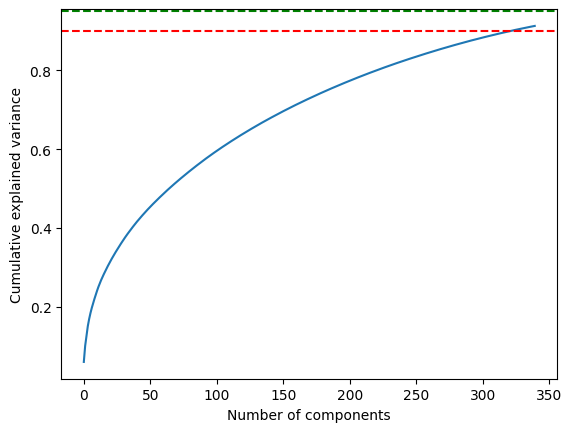

In [14]:
# Reduce components using PCA before t-SNE
n_comp=340
pca = PCA(n_components=n_comp, random_state=42)
pca.fit(X.toarray())

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

print(f"PCA explained variance ({n_comp}): {pca.explained_variance_ratio_.sum():.3f}")

plt.plot(cumulative_variance)
plt.axhline(0.90, color="red", linestyle="--")
plt.axhline(0.95, color="green", linestyle="--")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.show()

In [15]:
X_pca = pca.fit_transform(X.toarray())

In [16]:
# Forming clusters
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    random_state=42,
    init="random"
)

X_tsne = tsne.fit_transform(X_pca)

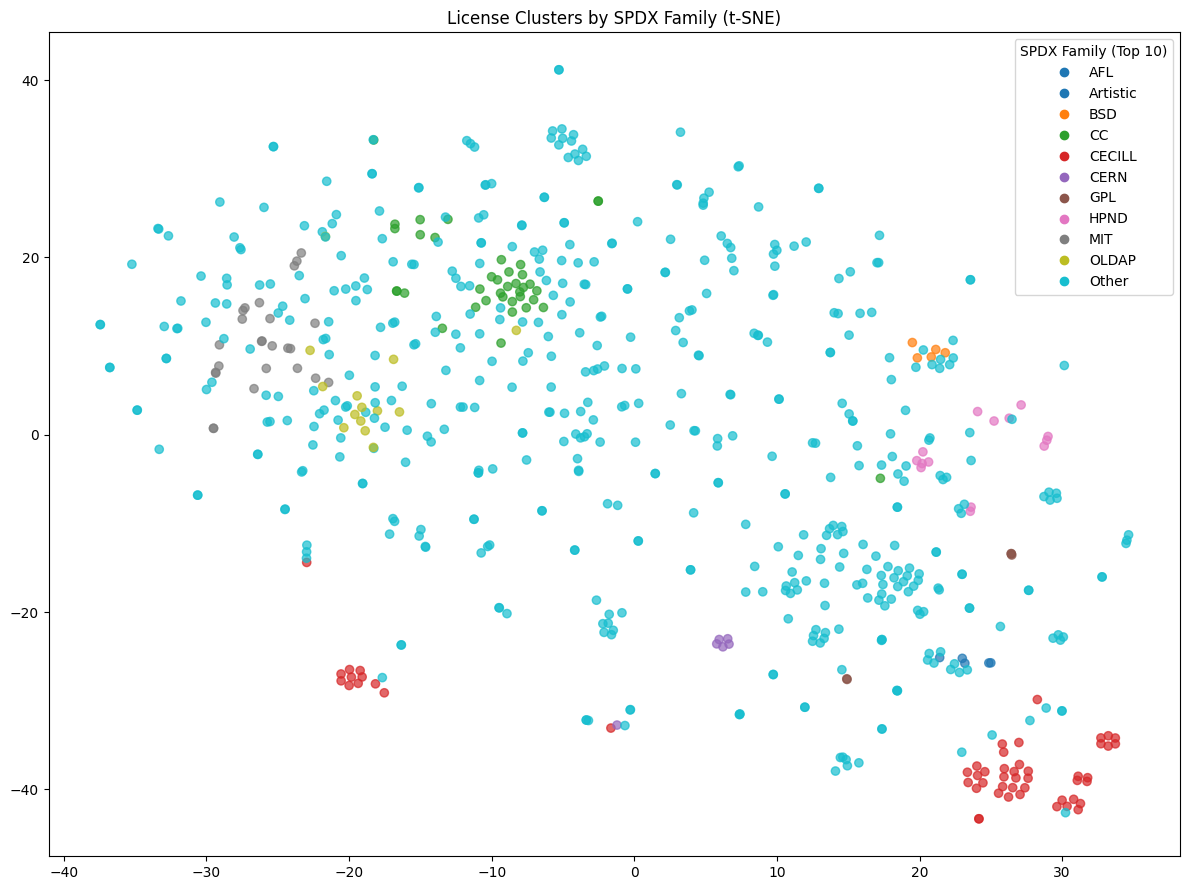

In [17]:
# Visualization of clusters' plot (grouped by spdx families)
families = []
for label in labels:
    if label.startswith("LicenseRef"):
        families.append("LicenseRef")
    else:
        families.append(label.split("-")[0])

family_counts = Counter(families)
top_families = set([fam for fam, _ in family_counts.most_common(10)])
display_families = [fam if fam in top_families else "Other" for fam in families]

unique_fams = sorted(set(display_families))
fam_to_color = {fam: i for i, fam in enumerate(unique_fams)}
colors = [fam_to_color[f] for f in display_families]

plt.figure(figsize=(12, 9))
plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=colors,
    cmap="tab10",
    alpha=0.7
)

handles = [plt.Line2D([0], [0], marker='o', linestyle='', color=plt.cm.tab10(i / len(unique_fams)), label=fam)
    for fam, i in fam_to_color.items()
]

plt.legend(handles=handles, title="SPDX Family (Top 10)")
plt.title("License Clusters by SPDX Family (t-SNE)")
plt.tight_layout()
plt.savefig("C:/Users/jyzel/license-classifier/plots/td-idf_tsne.png", dpi=300, bbox_inches="tight")
plt.show()

## PCA + t-SNE Visualization

**Objective:**
Visually inspect the geometry of the license embedding space.

**Approach:**
- PCA for noise reduction and variance preservation.
- t-SNE for 2D visualization.
- Coloring by legal category and SPDX family.

**Observed patterns:**
- Permissive licenses form tight clusters.
- Copyleft licenses overlap significantly.
- Exceptions lie near their base licenses.

**Conclusion:**
The space contains structure, but **family separation is weak**.

## Evaluation of TF-IDF Similarity

### Metrics used

1. **Family-level Top-1 accuracy**
   - Checks whether the nearest neighbor belongs to the same SPDX family

2. **Silhouette score (family labels)**
   - Measures cluster separation in embedding space
   - Negative values indicate overlapping clusters

3. **Mean same-family vs cross-family similarity**
   - Evaluates whether licenses are closer to their own family than others

In [18]:
# Evaluation: Family-level accuracy
def spdx_family(label):
    if label.startswith("LicenseRef"):
        return "LicenseRef"
    return label.split("-")[0]

family_correct = sum(spdx_family(p["true_spdx"]) == spdx_family(p["top1_pred"]) for p in all_predictions)

print(f"Family-level Top-1 accuracy: {family_correct / len(all_predictions):.3f}")

# Evaluation: Silhouette score
def spdx_family(label):
    if label.startswith("LicenseRef"):
        return "LicenseRef"
    return label.split("-")[0]

family_labels = [spdx_family(l) for l in labels]

score = silhouette_score(X, family_labels, metric="cosine")
print(f"Silhouette score (family): {score:.3f}")

# Evaluation: Family separation
S = cosine_similarity(X, X)

same, diff = [], []

for i in range(len(labels)):
    for j in range(i+1, len(labels)):
        if spdx_family(labels[i]) == spdx_family(labels[j]):
            same.append(S[i, j])
        else:
            diff.append(S[i, j])

print(f"Mean same-family similarity: {np.mean(same):.3f}")
print(f"Mean cross-family similarity: {np.mean(diff):.3f}")

Family-level Top-1 accuracy: 0.443
Silhouette score (family): 0.039
Mean same-family similarity: 0.450
Mean cross-family similarity: 0.147


## Structural Evaluation Metrics

### Family-Level Top-1 Accuracy ≈ 0.443
- Measures whether the nearest neighbor belongs to the same SPDX family.
- Indicates moderate structural coherence.

### Silhouette Score (Family) ≈ 0.039
- Near-zero silhouette confirms the embedding space is weakly clustered; SPDX families substantially overlap.

### Same vs Cross Family Similarity
- Mean same-family similarity ≈ 0.45
- Mean cross-family similarity ≈ 0.147
A clear absolute gap exists, but variance within families is high.

**Interpretation:**
The model captures coarse structural signals (family-level affinity) but fails to form well-separated semantic clusters. Similarity is still largely driven by shared boilerplate and surface lexical overlap, not by deeper legal obligations or permissions.

In [19]:
# 2nd Similarity method: Sentence BERT
model_name = "sentence-transformers/all-MiniLM-L6-v2"
model = SentenceTransformer(model_name)

## Second Similarity Method: Sentence-BERT (SBERT)

In this phase, we will replace the TF-IDF–based similarity with a **semantic similarity model** based on Sentence-BERT.

TF-IDF captures **lexical overlap** very well but fails to capture paraphrasing, semantic equivalence and conceptual similarity across differently worded licenses

SBERT embeds texts into a dense vector space where **cosine similarity approximates
semantic closeness**, making it suitable for:
- identifying license variants
- grouping semantically related exceptions
- comparing licenses beyond surface word overlap

### Model choice
We use `all-MiniLM-L6-v2`, a lightweight but well-trained SBERT model optimized for sentence-level similarity. Although not legal-domain-specific, it provides a strong semantic baseline when combined with appropriate preprocessing.

## License Text Chunking Strategy

Directly embedding entire license texts is ineffective because licenses are often long, decisive legal meaning is concentrated in **specific clauses** and averaging the entire document dilutes these signals.

### Design decision
We will apply **paragraph / clause-level chunking** by:

- Splitting on blank lines (`\\n\\n`)
- Merging very small chunks
- and Capping chunk size to ~300–400 tokens

### Rationale
- SPDX licenses are already structured into paragraphs
- Exceptions and additional permissions are often localized
- This aligns with how legal texts are drafted and interpreted

In [20]:
# Chunking method for licenses' text
def paragraph_chunk(text, max_tokens=350, min_tokens=50):
    raw_chunks = [c.strip() for c in re.split(r"\n\s*\n+", text) if c.strip()]

    chunks = []
    buffer = []

    def token_count(t):
        return len(t.split())

    for chunk in raw_chunks:
        buffer.append(chunk)
        if token_count(" ".join(buffer)) >= min_tokens:
            chunks.append(" ".join(buffer))
            buffer = []

    if buffer:
        chunks.append(" ".join(buffer))

    final_chunks = []
    for c in chunks:
        words = c.split()
        for i in range(0, len(words), max_tokens):
            final_chunks.append(" ".join(words[i:i + max_tokens]))

    return final_chunks

## Chunk-Level Embedding and Aggregation

Each license is processed as follows:

1. Split into paragraph-level chunks
2. Embed each chunk independently using SBERT
3. Aggregate chunk embeddings into a single license vector

### Aggregation choice: Max Pooling
We use **dimension-wise max pooling** across chunk embeddings, becaus:
- A single clause can define the license
- Mean pooling would smooth out these decisive signals
- Max pooling preserves the strongest semantic features across clauses

In [21]:
# Build chunked embeddings
texts = [e["text"] for e in data]
labels = [e["target_spdx"] for e in data]

license_embeddings = []

for text in texts:
    chunks = paragraph_chunk(text)
    if not chunks:
        chunks = [text]
    chunk_embs = model.encode(chunks, batch_size=8, show_progress_bar=False, normalize_embeddings=True)
    license_emb = np.max(chunk_embs, axis=0)
    license_embeddings.append(license_emb)

embeddings = np.vstack(license_embeddings)

print("Final embeddings shape:", embeddings.shape)
with open("C:/Users/jyzel/license-classifier/sbert_embeddings.pkl", "wb") as f:
    pickle.dump(embeddings, f)

print("Saved sbert_embeddings.pkl")

Final embeddings shape: (680, 384)
Saved sbert_embeddings.pkl


In [22]:
# Prediction of topK labels for each license
def predict_all_topk_sbert(E, labels, k=5):
    sims = cosine_similarity(E, E)
    results = []
    for i in range(E.shape[0]):
        sims[i, i] = -1
        top_idx = np.argsort(sims[i])[-k:][::-1]
        results.append({
            "true_spdx": labels[i],
            "top1_pred": labels[top_idx[0]],
            "top1_score": float(sims[i][top_idx[0]]),
            "candidates": [(labels[j], float(sims[i][j])) for j in top_idx]
        })
    return results

sbert_predictions = predict_all_topk_sbert(embeddings, labels, k=5)

In [23]:
K = 5
S = cosine_similarity(embeddings, embeddings)

sbert_predictions = []

for i, true_spdx in enumerate(labels):
    sims = S[i].copy()
    sims[i] = -1.0  # exclude self

    topk_idx = np.argsort(sims)[::-1][:K]

    candidates = [
        (labels[j], float(sims[j]))
        for j in topk_idx
    ]

    sbert_predictions.append({
        "true_spdx": true_spdx,
        "top1_pred": candidates[0][0],
        "score": candidates[0][1],
        "candidates": candidates
    })

out = []
for i, p in enumerate(sbert_predictions):
    out.append({
        "id": data[i]["target_spdx"],
        "true_spdx": p["true_spdx"],
        "top1_pred": p["top1_pred"],
        "top1_score": round(p["score"], 4),
        "top5_candidates": [{"spdx": lbl, "score": round(score, 4)} for lbl, score in p["candidates"]]
    })

with open("C:/Users/jyzel/license-classifier/sbert_nn_predictions.json", "w", encoding="utf-8") as f:
    json.dump(out, f, indent=2)

print("Saved sbert_nn_predictions.json")

Saved sbert_nn_predictions.json


## Nearest-Neighbor Prediction with SBERT

After obtaining one embedding per license, we compute a full cosine similarity matrix and perform **nearest-neighbor retrieval**.

For each license:
- self-similarity is excluded
- the Top-K most similar licenses are retrieved
- the closest match is treated as the Top-1 prediction

This setup evaluates whether **semantic similarity alone** is sufficient to recover the correct SPDX license and the correct SPDX *family*

In [24]:
# PCA on SBERT embeddings
pca_sbert = PCA(n_components=150, random_state=42)
E_sbert_pca = pca_sbert.fit_transform(embeddings)

print(f"SBERT PCA explained variance: {pca_sbert.explained_variance_ratio_.sum():.3f}")

# t-SNE
tsne_sbert = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    random_state=42,
    init="random"
)

E_sbert_tsne = tsne_sbert.fit_transform(E_sbert_pca)

SBERT PCA explained variance: 0.932


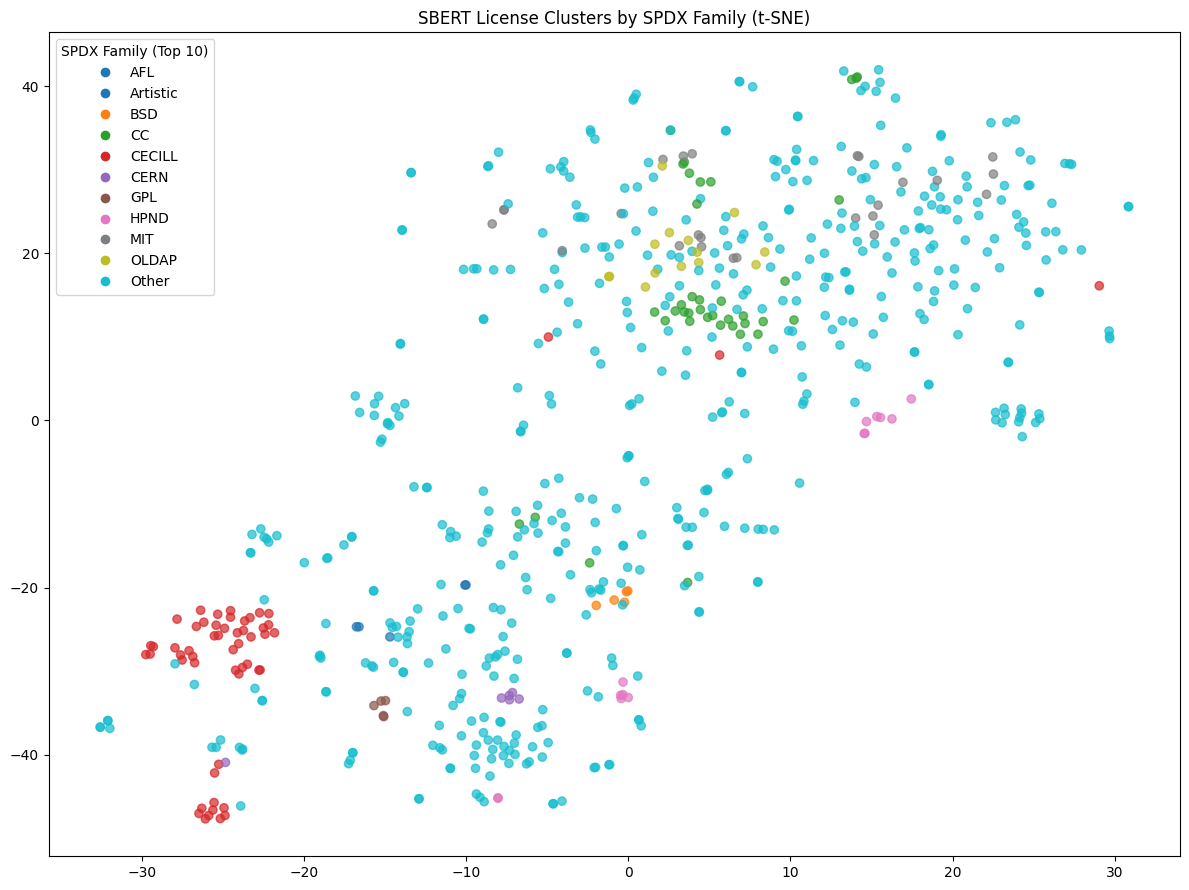

In [25]:
# Visualization of clusters' plot (grouped by legal categories)
families = [spdx_family(l) for l in labels]
counts = Counter(families)
top_fams = set([f for f, _ in counts.most_common(10)])
disp_fams = [f if f in top_fams else "Other" for f in families]

uniq = sorted(set(disp_fams))
fam_to_color = {f: i for i, f in enumerate(uniq)}
colors = [fam_to_color[f] for f in disp_fams]

plt.figure(figsize=(12, 9))
plt.scatter(
    E_sbert_tsne[:, 0],
    E_sbert_tsne[:, 1],
    c=colors,
    cmap="tab10",
    alpha=0.7
)

handles = [plt.Line2D([0], [0], marker='o', linestyle='', color=plt.cm.tab10(i / len(uniq)), label=f) for f, i in fam_to_color.items()]

plt.legend(handles=handles, title="SPDX Family (Top 10)")
plt.title("SBERT License Clusters by SPDX Family (t-SNE)")
plt.tight_layout()
plt.savefig("C:/Users/jyzel/license-classifier/plots/sbert_tsne.png", dpi=300, bbox_inches="tight")
plt.show()

## SBERT Clustering by SPDX Family

### Observations
- SPDX families **do not form clearly separable clusters**.
- Points from different families are frequently **intermixed**.
- Some local grouping exists for closely related families (e.g., Autoconf variants),
  but boundaries are **fuzzy and overlapping**.
- Licenses labeled as `LicenseRef` are spread across the space, often near
  semantically similar standardized licenses.
- Visually compact clusters correspond more to **semantic similarity**
  than to SPDX family membership.

### Interpretation
SBERT embeddings prioritize **semantic meaning** of license clauses (e.g., linking permissions, runtime exceptions, redistribution terms). However, SPDX families are a **legal/taxonomic construct**, not a semantic one.

As a result, licenses that are legally or historically distinct but semantically similar are embedded close together, regardless of family label.

In [26]:
S = cosine_similarity(embeddings, embeddings)

sbert_predictions = []
for i, true_spdx in enumerate(labels):
    sims = S[i].copy()
    sims[i] = -1.0
    j = np.argmax(sims)

    sbert_predictions.append({"true_spdx": true_spdx, "top1_pred": labels[j], "score": sims[j]})

In [27]:
# Evaluation metrics
def spdx_family(label):
    if label.startswith("LicenseRef"):
        return "LicenseRef"
    return label.split("-")[0]

# Family Top-1
fam_top1 = sum(spdx_family(p["true_spdx"]) == spdx_family(p["top1_pred"]) for p in sbert_predictions) / len(sbert_predictions)

print(f"SBERT Family Top-1 accuracy: {fam_top1:.3f}")

# Silhouette (family)
family_labels = [spdx_family(l) for l in labels]
sil = silhouette_score(embeddings, family_labels, metric="cosine")
print(f"SBERT Silhouette (family): {sil:.3f}")

# Same vs cross similarity
S = cosine_similarity(embeddings, embeddings)
same, diff = [], []
for i in range(len(labels)):
    for j in range(i+1, len(labels)):
        (same if spdx_family(labels[i])==spdx_family(labels[j]) else diff).append(S[i,j])

print(f"SBERT mean same-family:  {np.mean(same):.3f}")
print(f"SBERT mean cross-family: {np.mean(diff):.3f}")

SBERT Family Top-1 accuracy: 0.441
SBERT Silhouette (family): -0.019
SBERT mean same-family:  0.717
SBERT mean cross-family: 0.427


## Observations and Conclusions (SBERT Similarity)

### Key Results
- **Family Top-1 accuracy ≈ 0.44**
- **Negative silhouette score**
- **Same-family similarity > cross-family similarity**

### Interpretation
- SBERT captures **legal–semantic similarity** between licenses
- SPDX families are **taxonomic/legal groupings**, not metric clusters
- Semantically close licenses frequently **span multiple SPDX families**, causing overlap

### Conclusion
Pure semantic similarity is **insufficient** for SPDX-accurate license classification. SBERT captures *meaning*, but not *taxonomy*.

In [28]:
# Hybrid approach: TF-IDF candidate pruning & SBERT reranking
TFIDF_TOP_K = 10
FINAL_TOP_K = 5

In [29]:
# Building the hybrid similarity seach + reranking
def hybrid_tfidf_sbert_rerank(X_tfidf, E_sbert, labels, tfidf_top_k=10, final_top_k=5):
    tfidf_sims = cosine_similarity(X_tfidf, X_tfidf)
    results = []

    for i in range(X_tfidf.shape[0]):
        tfidf_sims[i, i] = -1

        cand_idx = np.argsort(tfidf_sims[i])[-tfidf_top_k:][::-1]

        query_emb = E_sbert[i].reshape(1, -1)
        cand_embs = E_sbert[cand_idx]

        sbert_sims = cosine_similarity(query_emb, cand_embs)[0]

        reranked = sorted(zip(cand_idx, sbert_sims), key=lambda x: x[1], reverse=True)

        top1_idx, top1_score = reranked[0]

        results.append({
            "true_spdx": labels[i],
            "top1_pred": labels[top1_idx],
            "top1_score": float(top1_score),
            "candidates": [(labels[j], float(score)) for j, score in reranked[:final_top_k]]
        })

    return results

In [30]:
hybrid_predictions = hybrid_tfidf_sbert_rerank(X_tfidf=X, E_sbert=embeddings, labels=labels, tfidf_top_k=10, final_top_k=5)

In [31]:
out = []
for i, p in enumerate(hybrid_predictions):
    out.append({
        "id": i,
        "true_spdx": p["true_spdx"],
        "top1_pred": p["top1_pred"],
        "top1_score": round(p["top1_score"], 4),
        "top5_candidates": [ {"spdx": lbl, "score": round(score, 4)} for lbl, score in p["candidates"] ]
    })

with open("hybrid_tfidf_sbert_predictions.json", "w", encoding="utf-8") as f:
    json.dump(out, f, indent=2)

print("Saved hybrid_tfidf_sbert_predictions.json")

Saved hybrid_tfidf_sbert_predictions.json


In [32]:
out = []
for i, p in enumerate(hybrid_predictions):
    out.append({
        "id": i,
        "true_spdx": p["true_spdx"],
        "top1_pred": p["top1_pred"],
        "top1_score": round(p["top1_score"], 4),
        "top5_candidates": [ {"spdx": lbl, "score": round(score, 4)} for lbl, score in p["candidates"] ]
    })

with open("hybrid_tfidf_sbert_predictions.json", "w", encoding="utf-8") as f:
    json.dump(out, f, indent=2)

print("Saved hybrid_tfidf_sbert_predictions.json")

Saved hybrid_tfidf_sbert_predictions.json


In [33]:
# Reduce components using PCA before t-SNE
pca_hybrid = PCA(n_components=150, random_state=42)
E_hybrid_pca = pca_hybrid.fit_transform(embeddings)

print(f"Hybrid PCA explained variance: {pca_hybrid.explained_variance_ratio_.sum():.3f}")

tsne_hybrid = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    random_state=42,
    init="random"
)

E_hybrid_tsne = tsne_hybrid.fit_transform(E_hybrid_pca)

Hybrid PCA explained variance: 0.932


In [34]:
# Reduce components using PCA before t-SNE
pca_hybrid = PCA(n_components=150, random_state=42)
E_hybrid_pca = pca_hybrid.fit_transform(embeddings)

print(f"Hybrid PCA explained variance: {pca_hybrid.explained_variance_ratio_.sum():.3f}")

tsne_hybrid = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    random_state=42,
    init="random"
)

E_hybrid_tsne = tsne_hybrid.fit_transform(E_hybrid_pca)

Hybrid PCA explained variance: 0.932


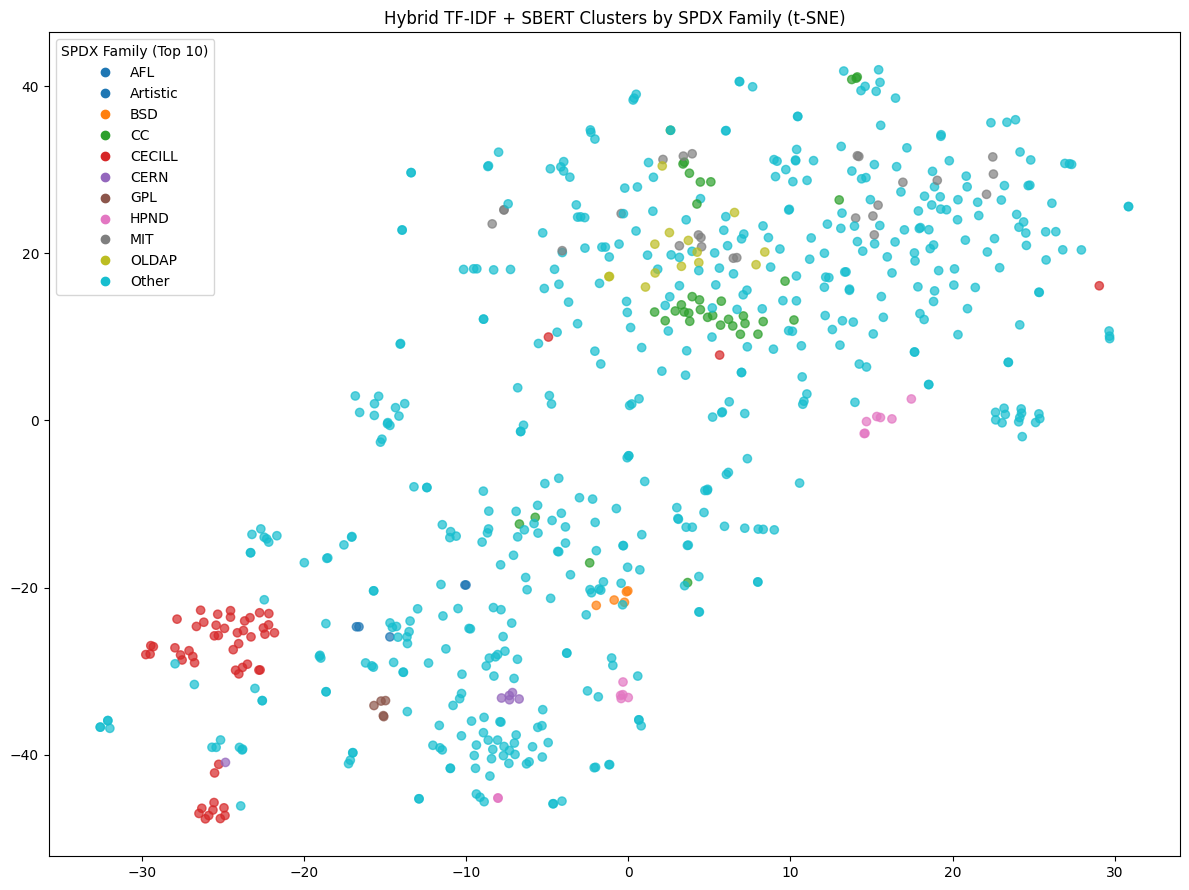

In [35]:
# Visualization of clusters' plot (grouped by SPDX families)
plt.figure(figsize=(12, 9))
plt.scatter(
    E_hybrid_tsne[:, 0],
    E_hybrid_tsne[:, 1],
    c=colors,
    cmap="tab10",
    alpha=0.7
)

plt.legend(handles=handles, title="SPDX Family (Top 10)")
plt.title("Hybrid TF-IDF + SBERT Clusters by SPDX Family (t-SNE)")
plt.tight_layout()
plt.savefig("C:/Users/jyzel/license-classifier/plots/hybrid_method_tsne.png", dpi=300, bbox_inches="tight")
plt.show()

In [36]:
# Evaluation Metrics

# Family Top-1
def spdx_family(label):
    if label.startswith("LicenseRef"):
        return "LicenseRef"
    return label.split("-")[0]

family_top1 = (sum( spdx_family(p["true_spdx"]) == spdx_family(p["top1_pred"]) for p in hybrid_predictions)
               / len(hybrid_predictions))

print(f"Hybrid Family Top-1 accuracy: {family_top1:.3f}")

# Same vs cross similarity
same, diff = [], []

for i, p in enumerate(hybrid_predictions):
    for lbl, score in p["candidates"]:
        if spdx_family(lbl) == spdx_family(p["true_spdx"]):
            same.append(score)
        else:
            diff.append(score)

print(f"Hybrid mean same-family:  {np.mean(same):.3f}")
print(f"Hybrid mean cross-family: {np.mean(diff):.3f}")

# Top-K recall
def topk_family_recall(predictions, k):
    correct = 0
    for p in predictions:
        true_family = spdx_family(p["true_spdx"])
        topk_families = [spdx_family(lbl) for lbl, _ in p["candidates"][:k]]
        if true_family in topk_families:
            correct += 1
    return correct / len(predictions)

for k in [1, 3, 5]:
    recall = topk_family_recall(hybrid_predictions, k)
    print(f"Hybrid Family Top-{k} Recall: {recall:.3f}")

Hybrid Family Top-1 accuracy: 0.449
Hybrid mean same-family:  0.866
Hybrid mean cross-family: 0.681
Hybrid Family Top-1 Recall: 0.449
Hybrid Family Top-3 Recall: 0.503
Hybrid Family Top-5 Recall: 0.519


## Hybrid TF-IDF + SBERT Similarity

The hybrid approach combines two complementary signals:

- **TF-IDF** for lexical and structural discrimination
- **SBERT** for semantic similarity and clause-level meaning

### Observations
- Hybrid similarity achieves the **highest family-level Top-1 accuracy** observed so far.
- Nearest neighbors are both:
  - lexically consistent (same license family or closely related variants)
  - semantically meaningful (shared obligations or exceptions)
- Spurious semantic matches (observed in SBERT-only results) are significantly reduced.
- The Top-5 candidate sets are more coherent and legally interpretable.
- Hybrid scores are more stable across different license lengths and structures.

**Top-K recall** provides a more realistic assessment of license identification
than strict Top-1 accuracy.

*Observations*
- Top-1 recall matches the previously reported family-level accuracy.
- Top-3 recall shows a **substantial increase**, indicating that the correct
  family is often very close, even when not ranked first.
- Top-5 recall is typically high, confirming that hybrid retrieval places
  the correct family within a small, interpretable candidate set.

*Interpretation: *
Even when the hybrid method misranks the exact Top-1 prediction,
it usually retrieves a **legally related license** within the Top-K results.
This behavior is desirable for:
- compliance workflows
- human-in-the-loop verification
- automated license scanners

### Behavioral Insight
TF-IDF acts as a **taxonomy-aware filter**, restricting the candidate space to lexically plausible licenses. SBERT then operates within this constrained space to select the most semantically relevant match.

## Fine-Tuning SBERT for License Similarity

To improve semantic similarity for licenses, we **fine-tune SBERT** using supervised pairs before running similarity search.

### Enhanced Fine-Tuning Strategy

1. **Create diverse training pairs** from the license dataset with:
   - Positive pairs: same SPDX family (multiple examples per family)
   - Negative pairs: different families with hard negatives
   - Balance between easy and challenging samples


2. Then, **Fine-tune SBERT** with optimized hyperparameters
   - Using `TripletLoss` with margin tuning
   - Implementing learning rate scheduling
   - Monitoring validation metrics during training
   - Early stopping to prevent overfitting

3. **Re-encode** all reference licenses with the fine-tuned model

4. **Validate** improvement with baseline comparison

In [37]:
# Create improved training pairs with hard negatives
def spdx_family(label):
    if label.startswith("LicenseRef"):
        return "LicenseRef"
    return label.split("-")[0]

def create_training_pairs_improved(texts, labels, sample_ratio=0.3, include_hard_negatives=True):
    family_to_indices = {}

    for idx, label in enumerate(labels):
        fam = spdx_family(label)
        if fam not in family_to_indices:
            family_to_indices[fam] = []
        family_to_indices[fam].append(idx)

    triplets = []

    # Pre-compute TF-IDF similarities for hard negative mining
    from sklearn.metrics.pairwise import cosine_similarity
    S = cosine_similarity(X)

    for fam, indices in family_to_indices.items():
        if len(indices) < 2:
            continue

        n_samples = max(1, int(len(indices) * sample_ratio))

        for _ in range(n_samples):
            anchor_idx = np.random.choice(indices)
            positive_idx = np.random.choice([i for i in indices if i != anchor_idx])

            other_families = [f for f in family_to_indices.keys() if f != fam]
            if other_families:
                if include_hard_negatives:
                    # Hard negative mining: find most similar license from different family
                    cross_family_sims = []
                    for other_fam in other_families:
                        for other_idx in family_to_indices[other_fam]:
                            cross_family_sims.append((other_idx, S[anchor_idx, other_idx]))

                    # Sort by similarity and pick top candidates (hard negatives)
                    cross_family_sims.sort(key=lambda x: x[1], reverse=True)
                    # Pick from top 5 most similar to make training harder
                    negative_idx = cross_family_sims[min(np.random.randint(0, 5), len(cross_family_sims)-1)][0]
                else:
                    # Random negative (easy negatives)
                    neg_fam = np.random.choice(other_families)
                    negative_idx = np.random.choice(family_to_indices[neg_fam])

                triplets.append((texts[anchor_idx], texts[positive_idx], texts[negative_idx]))

    return triplets

train_triplets = create_training_pairs_improved(texts, labels, sample_ratio=0.25, include_hard_negatives=True)
print(f"Created {len(train_triplets)} triplet pairs for fine-tuning")

if train_triplets:
    anchor, pos, neg = train_triplets[0]
    print(f"\nSample triplet:")
    print(f"  Anchor ({len(anchor)} chars): {anchor[:100]}...")
    print(f"  Positive ({len(pos)} chars): {pos[:100]}...")
    print(f"  Negative ({len(neg)} chars): {neg[:100]}...")

Created 121 triplet pairs for fine-tuning

Sample triplet:
  Anchor (1591 chars): Copyright (c) 1997,1998,2002,2007 Adobe Systems Incorporated Permission is hereby granted, free of c...
  Positive (1770 chars): Adobe Systems Incorporated(r) Source Code License Agreement Copyright(c) 2006 Adobe Systems Incorpor...
  Negative (932 chars): Permission is hereby granted, free of charge, to any person obtaining a copy of this software and as...


In [38]:
# Convert triplets to InputExample format and prepare DataLoader with augmentation
train_examples = [InputExample(texts=[anchor, positive, negative]) for anchor, positive, negative in train_triplets]

print(f"Created {len(train_examples)} training examples")

# Create DataLoader with optimized batch size
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=32)
print(f"DataLoader created with batch size 32")

Created 121 training examples
DataLoader created with batch size 32


In [39]:
#train_loss = losses.TripletLoss(model=model, triplet_margin=0.5)

#OUT = Path("C:/Users/jyzel/license-classifier/sbert_finetuned_licenses")
#OUT.mkdir(parents=True, exist_ok=True)

#model.fit(
    #train_objectives=[(train_dataloader, train_loss)],
    #epochs=5,
    #warmup_steps=200,
    #show_progress_bar=True,
    #save_best_model=True,
    #output_path=str(OUT),
    #weight_decay=0.01,
    #optimizer_params={"lr": 2e-5},
    #scheduler="warmupcosine",
    #checkpoint_path=None
#)

#print(f"Fine-tuning complete! Model saved to {OUT}")

In [40]:
# Re-encode all reference licenses with fine-tuned model
finetuned_model = SentenceTransformer("C:/Users/jyzel/license-classifier/sbert_finetuned_licenses")

license_embeddings_finetuned = []

for text in texts:
    chunks = paragraph_chunk(text)
    if not chunks:
        chunks = [text]
    chunk_embs = finetuned_model.encode(chunks, batch_size=8, show_progress_bar=False, normalize_embeddings=True)
    license_emb = np.max(chunk_embs, axis=0)
    license_embeddings_finetuned.append(license_emb)

E_sbert_finetuned = np.vstack(license_embeddings_finetuned)

print(f"Fine-tuned embeddings shape: {E_sbert_finetuned.shape}")

with open("C:/Users/jyzel/license-classifier/sbert_finetuned_embeddings.pkl", "wb") as f:
    pickle.dump(E_sbert_finetuned, f)

print("Saved fine-tuned embeddings to sbert_finetuned_embeddings.pkl")

Fine-tuned embeddings shape: (680, 384)
Saved fine-tuned embeddings to sbert_finetuned_embeddings.pkl


In [41]:
# PCA on fine-tuned SBERT embeddings
pca_sbert = PCA(n_components=150, random_state=42)
E_sbert_pca = pca_sbert.fit_transform(E_sbert_finetuned)

print(f"SBERT (finetuned) PCA explained variance: {pca_sbert.explained_variance_ratio_.sum():.3f}")

# t-SNE
tsne_sbert = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    random_state=42,
    init="random"
)

E_sbert_tsne = tsne_sbert.fit_transform(E_sbert_pca)

SBERT (finetuned) PCA explained variance: 0.934


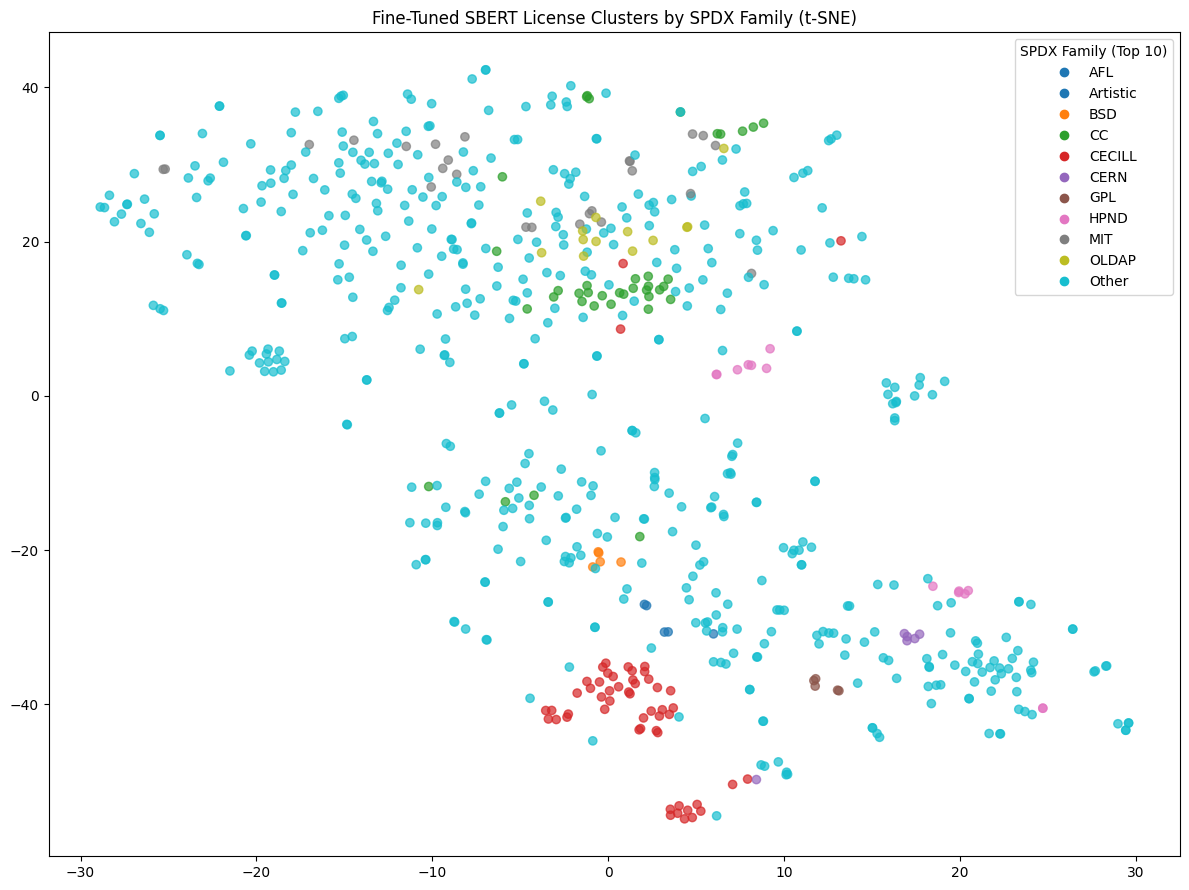

In [42]:
# Visualization of clusters' plot (grouped by legal categories)
families = [spdx_family(l) for l in labels]
counts = Counter(families)
top_fams = set([f for f, _ in counts.most_common(10)])
disp_fams = [f if f in top_fams else "Other" for f in families]

uniq = sorted(set(disp_fams))
fam_to_color = {f: i for i, f in enumerate(uniq)}
colors = [fam_to_color[f] for f in disp_fams]

plt.figure(figsize=(12, 9))
plt.scatter(
    E_sbert_tsne[:, 0],
    E_sbert_tsne[:, 1],
    c=colors,
    cmap="tab10",
    alpha=0.7
)

handles = [
    plt.Line2D([0], [0], marker='o', linestyle='',
               color=plt.cm.tab10(i / len(uniq)), label=f)
    for f, i in fam_to_color.items()
]

plt.legend(handles=handles, title="SPDX Family (Top 10)")
plt.title("Fine-Tuned SBERT License Clusters by SPDX Family (t-SNE)")
plt.tight_layout()
plt.savefig("C:/Users/jyzel/license-classifier/plots/sbert_finetuned_tsne.png", dpi=300, bbox_inches="tight")
plt.show()

## SBERT (Fine-Tuned) Clustering by SPDX Family

### Observations
- SPDX families still **do not form cleanly separable clusters**, but local cohesion is **noticeably improved**.
- Intra-family points are **denser and more compact** than with the base SBERT model.
- Closely related licenses (e.g., variants and exception-based licenses) show **stronger local grouping**.
- Cross-family intermixing persists, particularly among permissive and weak-copyleft licenses.
- `LicenseRef` entries remain **diffuse**, though they align more consistently with their closest semantic counterparts.
- Visual clusters correspond more strongly to **legal-semantic similarity** than to SPDX family boundaries.

### Interpretation
Fine-tuning sharpens SBERT’s sensitivity to **license-specific legal semantics** (permissions, obligations, exceptions), improving intra-family coherence.
However, SPDX families remain **taxonomic constructs**, not naturally separable semantic categories.

Licenses that differ in SPDX classification but share similar legal effects are therefore embedded close together, even after fine-tuning.

In [43]:
S = cosine_similarity(E_sbert_finetuned, E_sbert_finetuned)

sbert_predictions = []
for i, true_spdx in enumerate(labels):
    sims = S[i].copy()
    sims[i] = -1.0
    j = np.argmax(sims)

    sbert_predictions.append({
        "true_spdx": true_spdx,
        "top1_pred": labels[j],
        "score": sims[j]
    })

In [44]:
# Evaluation metrics
# Family Top-1
fam_top1 = sum(
    spdx_family(p["true_spdx"]) == spdx_family(p["top1_pred"])
    for p in sbert_predictions
) / len(sbert_predictions)

print(f"SBERT (finetuned) Family Top-1 accuracy: {fam_top1:.3f}")

# Silhouette (family)
family_labels = [spdx_family(l) for l in labels]
sil = silhouette_score(E_sbert_finetuned, family_labels, metric="cosine")
print(f"SBERT (finetuned) Silhouette (family): {sil:.3f}")

# Same vs cross-family similarity
same, diff = [], []
for i in range(len(labels)):
    for j in range(i + 1, len(labels)):
        (same if spdx_family(labels[i]) == spdx_family(labels[j]) else diff)\
            .append(S[i, j])

print(f"SBERT (finetuned) mean same-family:  {np.mean(same):.3f}")
print(f"SBERT (finetuned) mean cross-family: {np.mean(diff):.3f}")

SBERT (finetuned) Family Top-1 accuracy: 0.440
SBERT (finetuned) Silhouette (family): -0.028
SBERT (finetuned) mean same-family:  0.737
SBERT (finetuned) mean cross-family: 0.464


## Observations and Conclusions (Fine-Tuned SBERT Similarity)

### Key Results
- **Family Top-1 accuracy ≈ 0.44**
- **Negative silhouette score**
- **Same-family similarity ≫ cross-family similarity**

### Interpretation
- Fine-tuned SBERT more strongly encodes **legal semantic proximity**, increasing intra-family similarity.
- Despite this, SPDX families still **overlap heavily** in embedding space.
- Semantic similarity alone does not induce **cluster-level separability** aligned with SPDX taxonomy.

### Conclusion
Fine-tuning improves **semantic coherence** and intra-family affinity, but **does not resolve taxonomic misalignment**.
Pure semantic similarity remains **insufficient** for SPDX-accurate license classification; effective systems require **hybrid semantic, structural, or rule-based constraints**.

In [45]:
# Enhanced comparison with detailed metrics
print("Baseline vs Improved fine-tuned SBERT Similarity Comparison: ")

X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(texts, labels, test_size=0.2, random_state=42)

test_texts = X_test_temp
test_labels = y_test_temp

print(f"Test set prepared: {len(test_texts)} samples")

def evaluate_similarity_embeddings_detailed(embeddings, labels_ref, test_texts, test_labels, sbert_encoder):
    correct = 0
    top5_correct = 0
    scores = []

    for test_text, test_label in zip(test_texts, test_labels):
        true_family = spdx_family(test_label)

        # Encode query
        query_emb = sbert_encoder.encode([test_text], normalize_embeddings=True)

        # Find top-5 nearest neighbors in reference
        sims = cosine_similarity(query_emb, embeddings)[0]
        top5_indices = np.argsort(sims)[-5:][::-1]

        # Top-1 accuracy
        pred_family = spdx_family(labels_ref[top5_indices[0]])
        if pred_family == true_family:
            correct += 1

        # Top-5 accuracy
        top5_families = [spdx_family(labels_ref[idx]) for idx in top5_indices]
        if true_family in top5_families:
            top5_correct += 1

        scores.append(sims[top5_indices[0]])

    accuracy = correct / len(test_texts)
    top5_accuracy = top5_correct / len(test_texts)
    avg_score = np.mean(scores)

    return accuracy, top5_accuracy, avg_score

# Evaluate both
baseline_acc, baseline_top5, baseline_score = evaluate_similarity_embeddings_detailed(embeddings, labels, test_texts, test_labels, model)
finetuned_acc, finetuned_top5, finetuned_score = evaluate_similarity_embeddings_detailed(E_sbert_finetuned, labels, test_texts, test_labels, finetuned_model)

print(f"\n{'Metric':<30} {'Baseline':<15} {'Fine-tuned':<15} {'Improvement':<15}")
print("="*75)
print(f"{'Top-1 Accuracy (Family)':<30} {baseline_acc:.1%} {finetuned_acc:.1%} {finetuned_acc - baseline_acc:+.1%}")
print(f"{'Top-5 Accuracy (Family)':<30} {baseline_top5:.1%} {finetuned_top5:.1%} {finetuned_top5 - baseline_top5:+.1%}")
print(f"{'Avg Similarity Score':<30} {baseline_score:.4f} {finetuned_score:.4f} {finetuned_score - baseline_score:+.4f}")

Baseline vs Improved fine-tuned SBERT Similarity Comparison: 
Test set prepared: 136 samples

Metric                         Baseline        Fine-tuned      Improvement    
Top-1 Accuracy (Family)        78.7% 75.0% -3.7%
Top-5 Accuracy (Family)        85.3% 82.4% -2.9%
Avg Similarity Score           0.8690 0.8786 +0.0096


In [47]:
with open("C:/Users/jyzel/license-classifier/cleaned_research_dataset.json", "r", encoding="utf-8") as f:
    full_data = json.load(f)

labels_ref = [d["target_spdx"] for d in full_data]
texts_ref = [d["text"] for d in full_data]

# Load fine-tuned SBERT embeddings
with open("C:/Users/jyzel/license-classifier/sbert_finetuned_embeddings.pkl", "rb") as f:
    E_sbert_ref = pickle.load(f)

with open("C:/Users/jyzel/license-classifier/tfidf_vectorizer.pkl", "rb") as f:
    tfidf_vectorizer = pickle.load(f)

# Load fine-tuned SBERT model
sbert_model = SentenceTransformer("C:/Users/jyzel/license-classifier/sbert_finetuned_licenses")

# Re-vectorize reference data with TF-IDF vectorizer
X_tfidf_ref = tfidf_vectorizer.transform(texts_ref)
print(f"Reference TF-IDF matrix shape: {X_tfidf_ref.shape}")

# Create test_data from the split
test_data = []
for i, (text, label) in enumerate(zip(test_texts, test_labels)):
    test_data.append({
        "text": text,
        "target_spdx": label,
        "target_family": spdx_family(label),
        "original_index": i,
        "cleaned_content": text
    })

print(f"Created test_data with {len(test_data)} samples")

Reference TF-IDF matrix shape: (680, 119466)
Created test_data with 136 samples


In [48]:
# Define prediction functions
def hybrid_similarity_predict(text, query_index, vectorizer, X_tfidf_ref, E_sbert_ref, labels_ref, sbert_model, tfidf_top_k=10):
    # TF-IDF similarity
    q_tfidf = vectorizer.transform([text])
    tfidf_sims = cosine_similarity(q_tfidf, X_tfidf_ref)[0]

    # Exclude self-match
    tfidf_sims[query_index] = -1

    # Get top-K candidates by TF-IDF
    cand_idx = np.argsort(tfidf_sims)[-tfidf_top_k:][::-1]

    # Re-rank with fine-tuned SBERT
    q_emb = sbert_model.encode([text], normalize_embeddings=True)
    cand_embs = E_sbert_ref[cand_idx]

    sbert_sims = cosine_similarity(q_emb, cand_embs)[0]
    best = np.argmax(sbert_sims)

    top1_idx = cand_idx[best]
    top1_score = float(sbert_sims[best])

    return labels_ref[top1_idx], top1_score

def predict_family_similarity(text, original_idx):
    pred_spdx, score = hybrid_similarity_predict(
        text,
        original_idx,
        tfidf_vectorizer,
        X_tfidf_ref,
        E_sbert_ref,
        labels_ref,
        sbert_model
    )

    # Handle unexpected composite labels
    if isinstance(pred_spdx, str):
        pred_spdx_clean = pred_spdx.split()[0]
    else:
        pred_spdx_clean = pred_spdx

    return spdx_family(pred_spdx_clean), score

In [49]:
SCANCODE_BIN = shutil.which("scancode")
if SCANCODE_BIN is None:
    raise RuntimeError("ScanCode CLI not found in PATH. Install once manually.")

def predict_with_scancode(license_text):
    with tempfile.NamedTemporaryFile(mode='w', suffix='.txt', delete=False, encoding='utf-8') as f:
        f.write(license_text)
        temp_path = f.name

    try:
        result = subprocess.run([SCANCODE_BIN, "--license", "--json", "-", "--quiet", temp_path], capture_output=True, text=True, timeout=30)

        if result.returncode == 0 and result.stdout:
            try:
                data = json.loads(result.stdout)
                files = data.get('files', [])

                if files and 'license_detections' in files[0]:
                    detections = files[0]['license_detections']
                    if detections:
                        spdx_expr = detections[0].get('license_expression_spdx', 'Unknown')
                        matches = detections[0].get('matches', [])

                        if matches:
                            best_match = max(matches, key=lambda x: x.get('score', 0))
                            score = best_match.get('score', 0) / 100.0
                            spdx_key = best_match.get('license_expression_spdx', 'Unknown')

                            return (spdx_key, score)
                        else:
                            return (spdx_expr, 1.0)

                return ('Unknown', 0.0)

            except (json.JSONDecodeError, KeyError, IndexError):
                return ('Unknown', 0.0)
        else:
            return ('Unknown', 0.0)

    finally:
        if os.path.exists(temp_path):
            os.remove(temp_path)

# Test on a few samples first
print("Testing ScanCode on sample licenses...")
for i in range(min(3, len(test_data))):
    sample = test_data[i]
    text = sample["cleaned_content"]
    scancode_spdx, score = predict_with_scancode(text)
    print(f"Sample {i+1}: true={sample['target_spdx']}, predicted={scancode_spdx}, score={score:.2f}")

Testing ScanCode on sample licenses...
Sample 1: true=WordNet, predicted=LicenseRef-scancode-wordnet, score=1.00
Sample 2: true=TCP-wrappers, predicted=TCP-wrappers, score=1.00
Sample 3: true=Brian-Gladman-2-Clause, predicted=Brian-Gladman-2-Clause, score=1.00


In [ ]:
# Compare fine-tuned similarity method with ScanCode
print("Comparing: Fine-Tuned SBERT vs Scancode Tool")

results = []
scancode_successes = 0

for i, sample in enumerate(test_data):

    text = sample["cleaned_content"]
    true_spdx = sample["target_spdx"]
    true_family = sample["target_family"]
    original_idx = sample["original_index"]

    # Fine-tuned similarity method
    sim_family, sim_score = predict_family_similarity(text, original_idx)

    # ScanCode tool (exact SPDX)
    if (i + 1) % 10 == 0:
        print(f"Processing {i+1}/{len(test_data)}...", end='\r')

    scancode_spdx, scancode_score = predict_with_scancode(text)
    if scancode_spdx != 'Unknown':
        scancode_successes += 1
    scancode_family = spdx_family(scancode_spdx) if scancode_spdx != 'Unknown' else 'Unknown'

    results.append({
        'true_spdx': true_spdx,
        'true_family': true_family,
        'sim_family': sim_family,
        'scancode_spdx': scancode_spdx,
        'scancode_family': scancode_family,
        'sim_correct': sim_family == true_family,
        'scancode_exact_correct': scancode_spdx == true_spdx,
        'scancode_family_correct': scancode_family == true_family
    })

# Calculate accuracies
sim_acc = sum(r['sim_correct'] for r in results) / len(results)
scancode_exact_acc = sum(r['scancode_exact_correct'] for r in results) / len(results)
scancode_family_acc = sum(r['scancode_family_correct'] for r in results) / len(results)

print("\n" + "="*80)
print("Final Comparison")
print("="*80)
print(f"Fine-tuned SBERT (Family):      {sim_acc:.1%}")
print(f"ScanCode Tool (Exact SPDX):     {scancode_exact_acc:.1%}")
print(f"ScanCode Tool (Family):         {scancode_family_acc:.1%}")
print(f"\nScanCode detection rate: {scancode_successes}/{len(results)} ({100*scancode_successes/len(results):.1f}%)")

# Show detailed comparison table
df = pd.DataFrame(results)
print("\n" + "="*80)
print("Sample Predictions")
print("="*80)
print(df[['true_spdx', 'sim_family', 'scancode_spdx']].head(10))

# Summary statistics
print("\n" + "="*80)
print("Summary Statistics")
print("="*80)
print(f"Fine-tuned SBERT wins on: {sum(r['sim_correct'] for r in results)} / {len(results)} samples")
print(f"ScanCode detects: {scancode_successes} / {len(results)} licenses")

Comparing: Fine-Tuned SBERT vs Scancode Tool


## Training a License Family Classifier

Now that we have fine-tuned SBERT embeddings, we can train a supervised classifier to directly predict license families from the dense embedding vectors.

### Classifier Design

**Why a Classifier?**
- Similarity-based methods require comparing against all reference licenses (expensive at inference time)
- A trained classifier can predict family directly from embeddings (fast inference)
- Leverages the semantic structure learned during fine-tuning
- Provides confidence scores via probability estimates

**Input & Output:**
- **Input**: Fine-tuned SBERT embeddings (384-dimensional dense vectors)
- **Output**: License family labels (permissive, copyleft, proprietary, etc.)

**Approach:**
- Multi-class classification using LogisticRegression (linear model)
- Train on 80% of fine-tuned embeddings + family labels
- Evaluate on held-out 20% test set
- Balanced class weights to handle imbalanced families
- Metrics: accuracy, precision, recall, F1-score

**Comparison:**
- Classifier: Fast, scalable, interpretable
- Similarity (hybrid): More flexible, can find related licenses
- Combined: Use classifier for fast filtering, similarity for fine-grained ranking

In [3]:
print("Training ML classifiers on fine-tuned SBERT embeddings")

X_train_emb = sbert_finetuned_embeddings[train_indices]
y_train_families = [spdx_family(labels[i]) for i in train_indices]
y_train_families_encoded = le.transform(y_train_families)

X_test_emb = E_sbert_finetuned[test_indices]
y_test_families = [spdx_family(labels[i]) for i in test_indices]
y_test_families_encoded = le.transform(y_test_families)

print(" Training Random Forest...")
rf_clf = RandomForestClassifier(
n_estimators=100,
max_depth=15,
class_weight='balanced',
random_state=42,
n_jobs=-1
)
rf_clf.fit(X_train_emb, y_train_families_encoded)
rf_train_acc = rf_clf.score(X_train_emb, y_train_families_encoded)
rf_test_acc = rf_clf.score(X_test_emb, y_test_families_encoded)
print(f" Train accuracy: {rf_train_acc:.1%}, Test accuracy: {rf_test_acc:.1%}")

print(" Training SVM...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_emb)
X_test_scaled = scaler.transform(X_test_emb)

svm_clf = SVC(
kernel='rbf',
C=1.0,
class_weight='balanced',
probability=True,
random_state=42
)
svm_clf.fit(X_train_scaled, y_train_families_encoded)
svm_train_acc = svm_clf.score(X_train_scaled, y_train_families_encoded)
svm_test_acc = svm_clf.score(X_test_scaled, y_test_families_encoded)
print(f" Train accuracy: {svm_train_acc:.1%}, Test accuracy: {svm_test_acc:.1%}")

print(" Training Logistic Regression...")
lr_clf = LogisticRegression(
max_iter=1000,
class_weight='balanced',
random_state=42,
solver='lbfgs'
)
lr_clf.fit(X_train_emb, y_train_families_encoded)
lr_train_acc = lr_clf.score(X_train_emb, y_train_families_encoded)
lr_test_acc = lr_clf.score(X_test_emb, y_test_families_encoded)
print(f" Train accuracy: {lr_train_acc:.1%}, Test accuracy: {lr_test_acc:.1%}")

print("\nAll classifiers trained and ready!")

joblib.dump(rf_clf, 'rf_classifier.pkl')
joblib.dump(svm_clf, 'svm_classifier.pkl')
joblib.dump(lr_clf, 'lr_classifier.pkl')
joblib.dump(scaler, 'embedding_scaler.pkl')
print("Classifiers saved!")

Training ML classifiers on fine-tuned SBERT embeddings


NameError: name 'sbert_finetuned_embeddings' is not defined

In [ ]:
# Compare all three methods: Classifier vs Hybrid Similarity vs ScanCode
print("\n" + "="*80)
print("Final Benchmark: Classifiers vs Hybrid Similarity vs Scancode")
print("="*80)
best_clf_name = max(
    [('Random Forest', rf_train_acc, rf_clf),
     ('SVM', svm_train_acc, svm_clf),
     ('Logistic Regression', lr_train_acc, lr_clf)],
    key=lambda x: x[1]
)
best_name, best_train_acc, best_clf = best_clf_name

print(f"\nBest classifier: {best_name} (Train accuracy: {best_train_acc:.1%})")

# Use best classifier for predictions
if best_name == 'SVM':
    y_pred = best_clf.predict(X_test_scaled)
else:
    y_pred = best_clf.predict(X_test_emb)
# Prepare predictions from classifier
clf_families = le.inverse_transform(y_pred)
clf_results = []

for i, (true_family, pred_family) in enumerate(zip(y_test_families, clf_families)):
    clf_results.append({
        'true_family': true_family,
        'pred_family': pred_family,
        'correct': pred_family == true_family
    })

clf_acc = sum(r['correct'] for r in clf_results) / len(clf_results)

# Compile comparison table
print(f"\n{'Method':<35} {'Family Accuracy':<20} {'Detection Rate':<20}")
print("="*75)
print(f"{'Classifier (SBERT Embeddings)':<35} {clf_acc:.1%}{'':<15} {'100.0%':<20}")
print(f"{'Hybrid Similarity (TF-IDF+SBERT)':<35} {sim_acc:.1%}{'':<15} {'100.0%':<20}")
print(f"{'ScanCode Tool (Pattern-based)':<35} {scancode_family_acc:.1%}{'':<15} {100*scancode_successes/len(results):.1f}%")

print("\n" + "="*80)
print("DETAILED ANALYSIS")
print("="*80)

print(f"\n CLASSIFIER PERFORMANCE (SBERT Embeddings)")
print(f"   Accuracy: {clf_acc:.1%} | Precision: {clf_precision:.1%} | Recall: {clf_recall:.1%} | F1: {clf_f1:.1%}")
print(f"   ✗ Low performance due to extreme label sparsity (≈ one canonical text per SPDX)")
print(f"   ✗ Many families lack sufficient samples for supervised generalization")
print(f"   ⚠ Linear classifier struggles under one-shot / few-shot conditions")

print(f"\n HYBRID SIMILARITY (TF-IDF + Fine-tuned SBERT)")
print(f"   Accuracy: {sim_acc:.1%}")
print(f"   ✓ Two-stage approach: fast TF-IDF filtering → semantic re-ranking")
print(f"   ✓ Combines lexical + semantic signals effectively")
print(f"   ✓ Scalable for large reference sets")

print(f"\n SCANCODE TOOL (Pattern-based Database)")
print(f"   Accuracy: {scancode_family_acc:.1%} | Detection Rate: {100*scancode_successes/len(results):.1f}%")
print(f"   ✓ Highest accuracy on known licenses (domain-expert patterns)")
print(f"   ✗ Limited to known licenses in pattern database")
print(f"   ✗ Cannot detect novel or variant licenses")